In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNetV2
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
%matplotlib inline

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [3]:
training_set= tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [4]:
class_names = training_set.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    "val",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1000 files belonging to 10 classes.


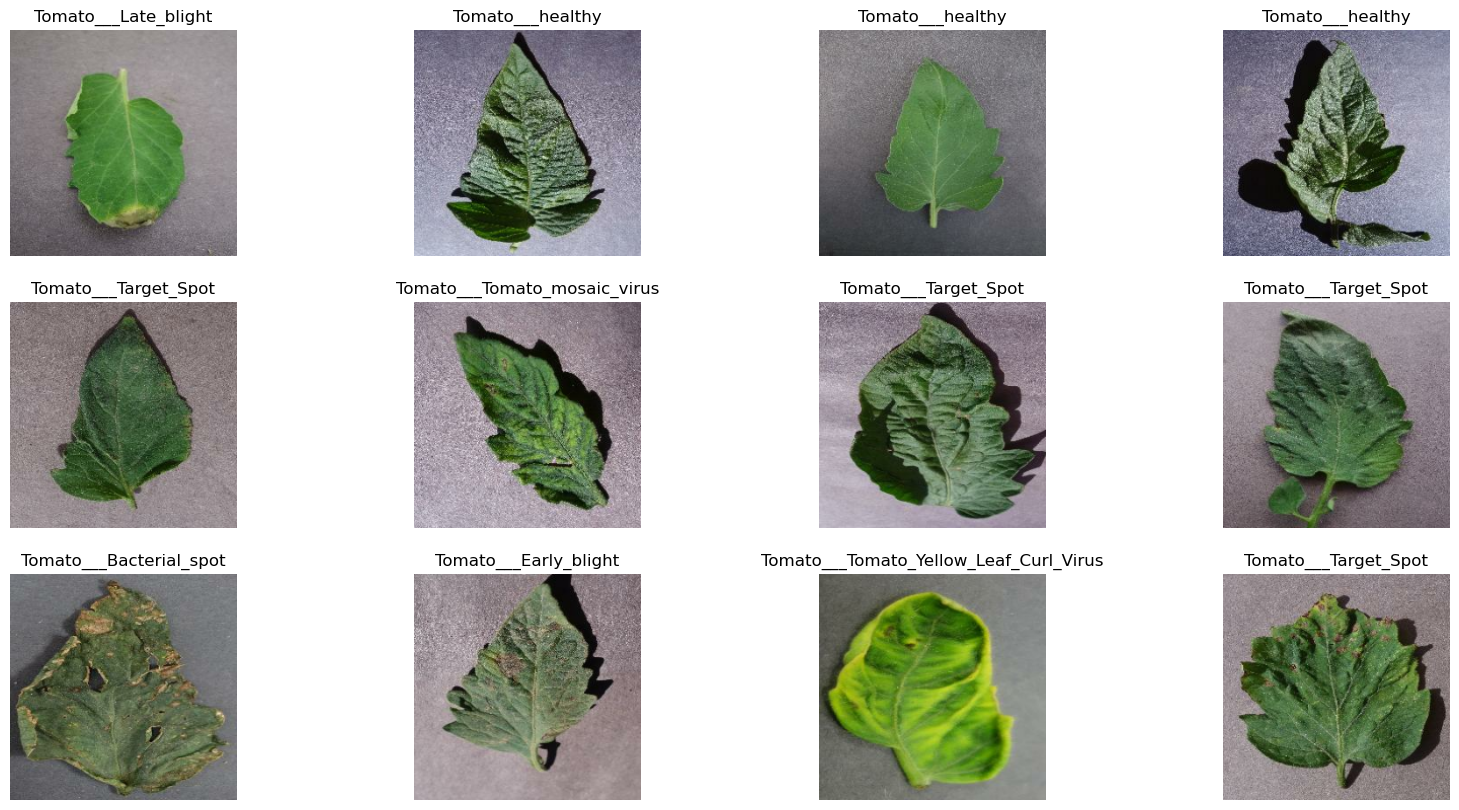

In [6]:
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds


In [18]:
train_ds, test_ds = get_dataset_partitions_tf(training_set)

In [19]:
len(training_set)

313

In [20]:
len(train_ds)

250

In [21]:
len(test_ds)

63

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
len(val_ds)

32

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = 224  
CHANNELS = 3
n_classes = 10

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

MobileNetV2_model = Sequential()

pretrained_model = MobileNetV2(include_top=False,
                               input_shape=input_shape,
                               pooling='avg',
                               weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

MobileNetV2_model.add(pretrained_model)

# Resize and rescale layer
MobileNetV2_model.add(resize_and_rescale)

# Flatten layer
MobileNetV2_model.add(Flatten())

# Dense layers
MobileNetV2_model.add(Dense(512, activation='relu'))
MobileNetV2_model.add(BatchNormalization())
MobileNetV2_model.add(Dropout(0.5))

MobileNetV2_model.add(Dense(256, activation='relu'))
MobileNetV2_model.add(BatchNormalization())
MobileNetV2_model.add(Dropout(0.5))

# Output layer
MobileNetV2_model.add(Dense(n_classes, activation='softmax'))

# Compile the model
MobileNetV2_model.compile(optimizer=Adam(),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

MobileNetV2_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 sequential_1 (Sequential)   (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)              

In [96]:
# BATCH_SIZE = 32
# IMAGE_SIZE = 224  
# CHANNELS = 3
# n_classes = 10

# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# MobileNetV2_model = Sequential()

# pretrained_model = MobileNetV2(include_top=False,
#                                input_shape=input_shape,
#                                pooling='avg',
#                                weights='imagenet')

# for layer in pretrained_model.layers:
#     layer.trainable = False

# MobileNetV2_model.add(pretrained_model)
# MobileNetV2_model.add(resize_and_rescale)
# MobileNetV2_model.add(Flatten())
# MobileNetV2_model.add(Dense(512, activation='relu'))
# MobileNetV2_model.add(Dense(n_classes, activation='softmax'))

In [42]:
# MobileNetV2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 sequential (Sequential)     (None, 1280)              0         
                                                                 
 module_wrapper (ModuleWrap  (None, 1280)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 512)               655872    
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 10)                5130      
 apper)                                               

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [13]:
MobileNetV2_model.compile(optimizer=opt,
                          loss="sparse_categorical_crossentropy",
                          metrics=['accuracy'])

In [137]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 20, 
                   verbose = 1, 
                   restore_best_weights = True)

In [139]:
epochs=50
history = MobileNetV2_model.fit(
    training_set,
    callbacks=[es],
    batch_size=32,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
313/313 [==============================] - 67s 214ms/step - loss: 1.2024 - accuracy: 0.6017 - val_loss: 2.1181 - val_accuracy: 0.1850
Epoch 2/50
313/313 [==============================] - 73s 232ms/step - loss: 0.8984 - accuracy: 0.6965 - val_loss: 1.0102 - val_accuracy: 0.6650
Epoch 3/50
313/313 [==============================] - 77s 245ms/step - loss: 0.7773 - accuracy: 0.7268 - val_loss: 1.1630 - val_accuracy: 0.6300
Epoch 4/50
313/313 [==============================] - 75s 241ms/step - loss: 0.7307 - accuracy: 0.7470 - val_loss: 0.7690 - val_accuracy: 0.7520
Epoch 5/50
313/313 [==============================] - 77s 246ms/step - loss: 0.6547 - accuracy: 0.7747 - val_loss: 0.6670 - val_accuracy: 0.7760
Epoch 6/50
313/313 [==============================] - 77s 247ms/step - loss: 0.6234 - accuracy: 0.7838 - val_loss: 0.7603 - val_accuracy: 0.7560
Epoch 7/50
313/313 [==============================] - 81s 260ms/step - loss: 0.6045 - accuracy: 0.7813 - val_loss: 0.6710 - val_ac

In [140]:
scores = MobileNetV2_model.evaluate(test_ds)

63/63 [==============================] - 14s 223ms/step - loss: 0.2776 - accuracy: 0.9008


In [141]:
scores

[0.27759820222854614, 0.9007936716079712]

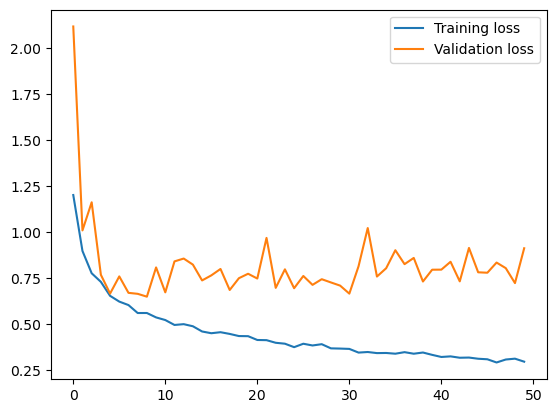

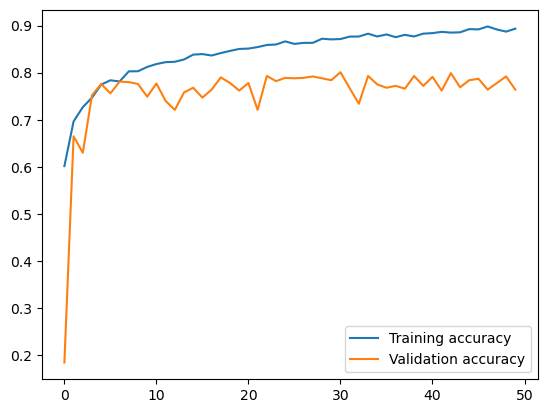

In [142]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

actual label: Tomato___Early_blight
1/1 [==============================] - 0s 277ms/step
predicted label: Tomato___Early_blight


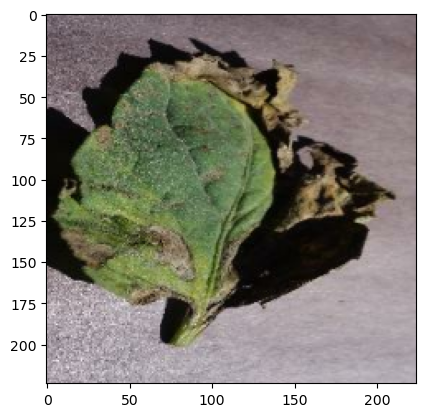

In [145]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = MobileNetV2_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [144]:
MobileNetV2_model.save("/Users/vidhan/Vidhan/data/Deep Learning/Projects/tomato_dataset/Model 50 epochs")

INFO:tensorflow:Assets written to: /Users/vidhan/Vidhan/data/Deep Learning/Projects/tomato_dataset/Model 50 epochs/assets


INFO:tensorflow:Assets written to: /Users/vidhan/Vidhan/data/Deep Learning/Projects/tomato_dataset/Model 50 epochs/assets


In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


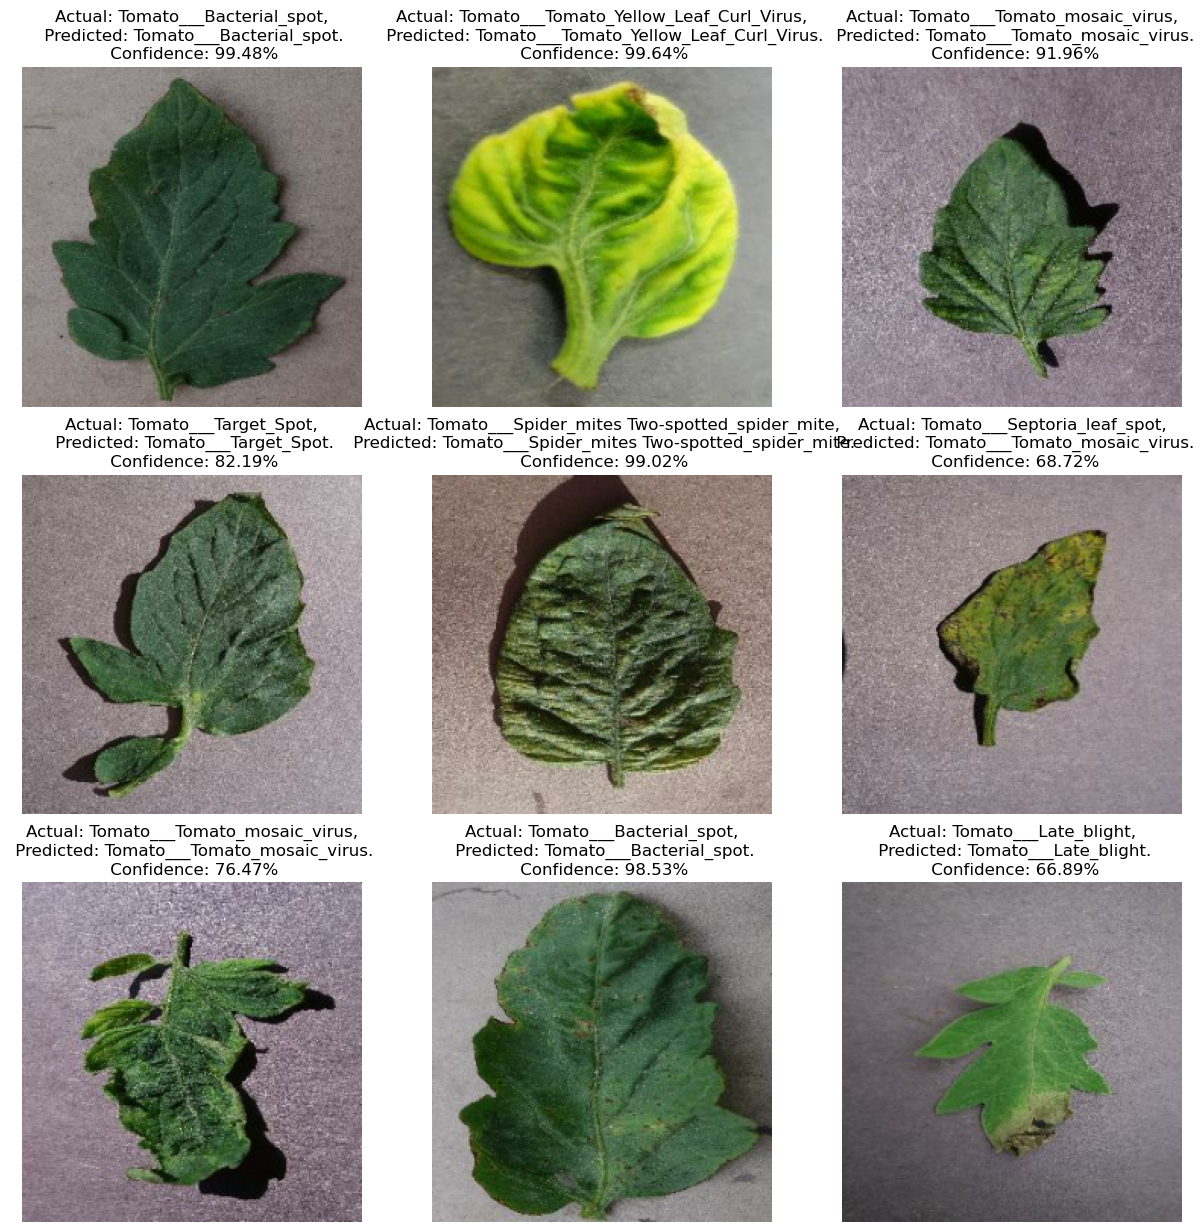

In [75]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(MobileNetV2_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [14]:
model = tf.keras.models.load_model("/Users/vidhan/Vidhan/data/Deep Learning/Projects/tomato_dataset/Model 50 epochs")

In [15]:
def predict(model, img):
    img = tf.image.resize(img, (224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


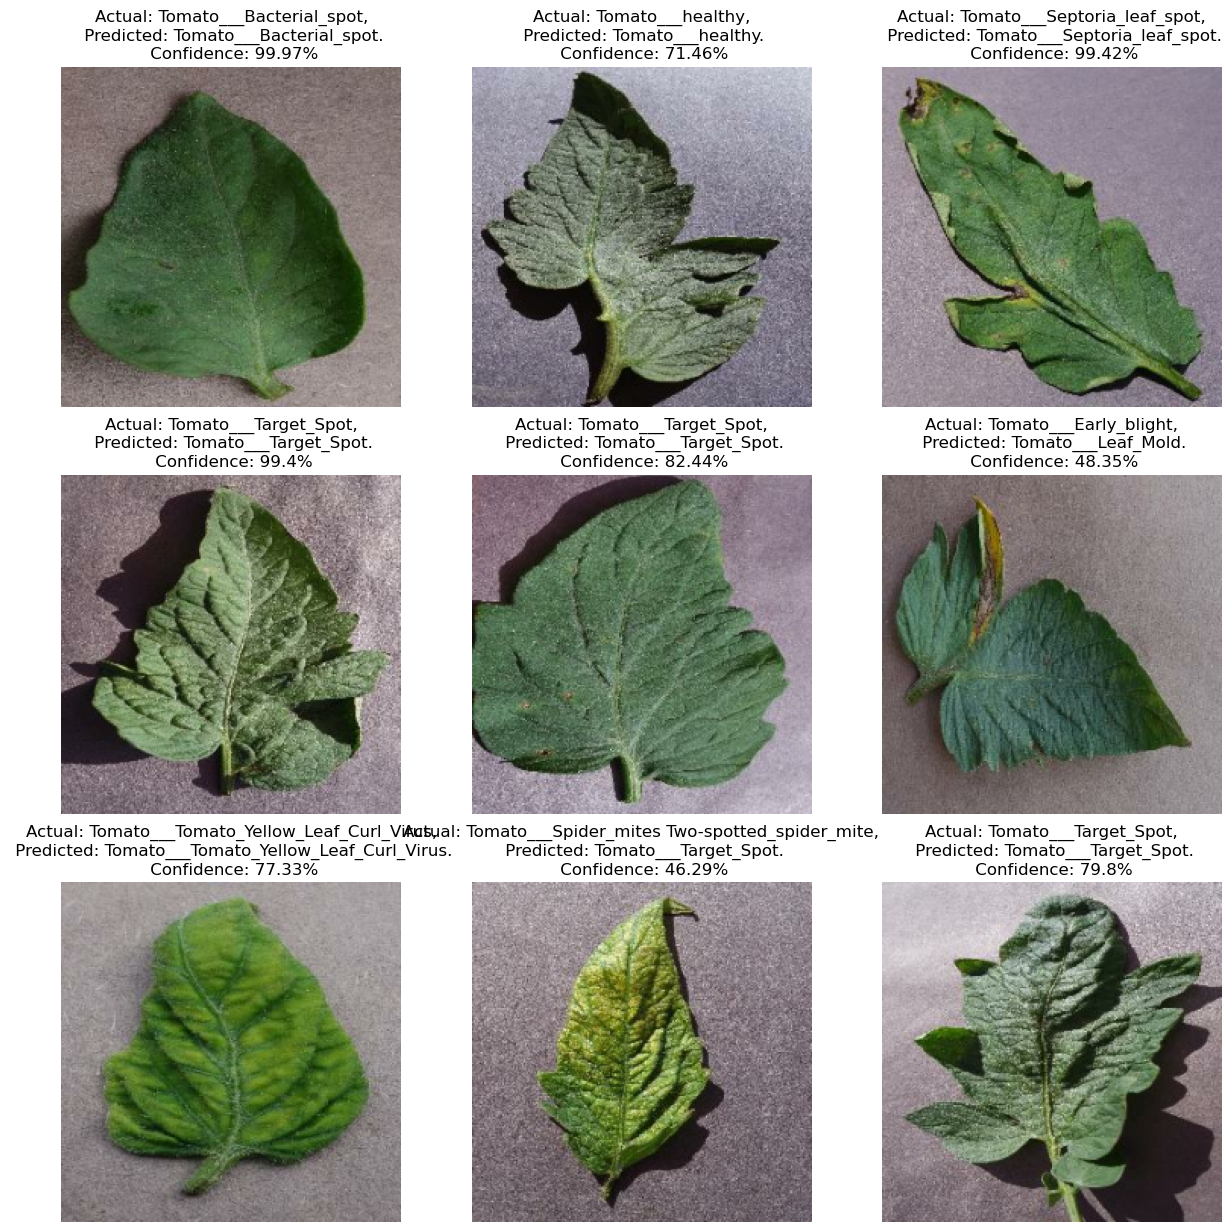

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [24]:
import gradio as gr

In [25]:
def predict_gradio(img):
    img = tf.image.resize(img, (224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class

In [28]:
interface = gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(),
    
    outputs=gr.Label(num_top_classes=10)
)

In [29]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
